In [2]:
# Always keep all inputs up top in the first cell. Use the second cellto load and clean the data.
# It happens frequently that imports are not available or you work on uncleaned data. 
# Having the source (i.e. the raw data set) availble helps getting to the bottom of weird behavior.

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# let's check our versions, just to be sure where to look for help
# I used 'dir(pd)' to check for available methods and found '__version__'

print("Pandas:",pd.__version__,"| Numpy:",np.__version__,"| Matplotlib:",matplotlib.__version__)


Pandas: 1.4.4 | Numpy: 1.23.3 | Matplotlib: 3.5.3


## Clean the Data Tables - real quick

Let's load the data and apply some cosmetic changes to column names. Makes things clearer.

In [20]:
# ALWAYS WORK FROM THE RAW DATA SET AND CHAIN METHODS as shown below. No changing, no confusion.

df = pd.read_csv("life-expectancy-vs-healthcare-expenditure.csv")

# We are renaming columns for the original CSV to make them easier to approach in python.
df = df.rename(columns={
    'Entity': 'Country', 
    'Code': 'Code',
    'Life expectancy at birth, total (years)': 'Life_Expectancy', # in years
    'Current health expenditure per capita, PPP (current international $)': 'Health_Expenditure', # in Dollars
    'Population (historical estimates)': 'Population', # historical estimates
    'Continent': 'Continent',
})


# Here we are doing some basic clean-up of data types. This helps to reduce the size of the loaded data in memory.
# While this is not crucial with the size of the data set we use here. This practice is very important to allow using
# larger datasets at all and make computations on them more efficient.
# Take a look at all available data types by checking the Pandas documentation

# Read on to see why this statement could be handy here :-)
# print("Memory:", df.memory_usage(deep=True).sum())

df = (df
 .assign(Health_Expenditure = df.Health_Expenditure.fillna(0).astype('float16'), # Population and HealthE Expenditure can grow inifinitely though, but Int Values are sensible, too...
         Population = df.Population.fillna(0).astype('Int64'),
         Life_Expectancy = df.Life_Expectancy.fillna(0).astype('float16'),  # should be within clear limits what life expectancy can be, float8 is only a theoretical option though
 )
 .astype({
     'Code' : 'category', # Categorial Values assign a numeric value to a category and hence save memory
     'Country': 'category', 
     'Continent': 'category',
     'Year': 'uint16', # Years are also within clear positive int bounds, so no need to reserve more space for them
 })
)

df = df[df.Health_Expenditure > 0]
df.to_json('health_exp_clean.json', orient='records')
df

,Country,Code,Year,Life_Expectancy,Health_Expenditure,Population,Continent
43,Afghanistan,AFG,2002,56.78125,81.2500,22600774,NaN
44,Afghanistan,AFG,2003,57.28125,82.4375,23680871,NaN
45,Afghanistan,AFG,2004,57.78125,89.5000,24726689,NaN
46,Afghanistan,AFG,2005,58.28125,100.6875,25654274,NaN
47,Afghanistan,AFG,2006,58.81250,113.7500,26433058,NaN
...,...,...,...,...,...,...,...
56332,Zimbabwe,ZWE,2015,59.53125,199.6250,13814642,Africa
56333,Zimbabwe,ZWE,2016,60.28125,215.3750,14030338,NaN
56334,Zimbabwe,ZWE,2017,60.81250,226.2500,14236599,NaN
56335,Zimbabwe,ZWE,2018,61.18750,269.2500,14438812,NaN


In [5]:
# We can check the size of our data like this. You might want to do a "before and after" to see the effect of
# changing our data types

print("Memory:", df.memory_usage(deep=True).sum())

df.Health_Expenditure.describe()

Memory: 168401


count    4.034000e+03
mean              inf
std               inf
min      6.929688e+00
25%      1.703438e+02
50%      5.405000e+02
75%      1.454000e+03
max      1.092000e+04
Name: Health_Expenditure, dtype: float64

## Plot the Data - real quick

Plotting is easy. Let's just use all the builtin functionality and get to a result quickly. 

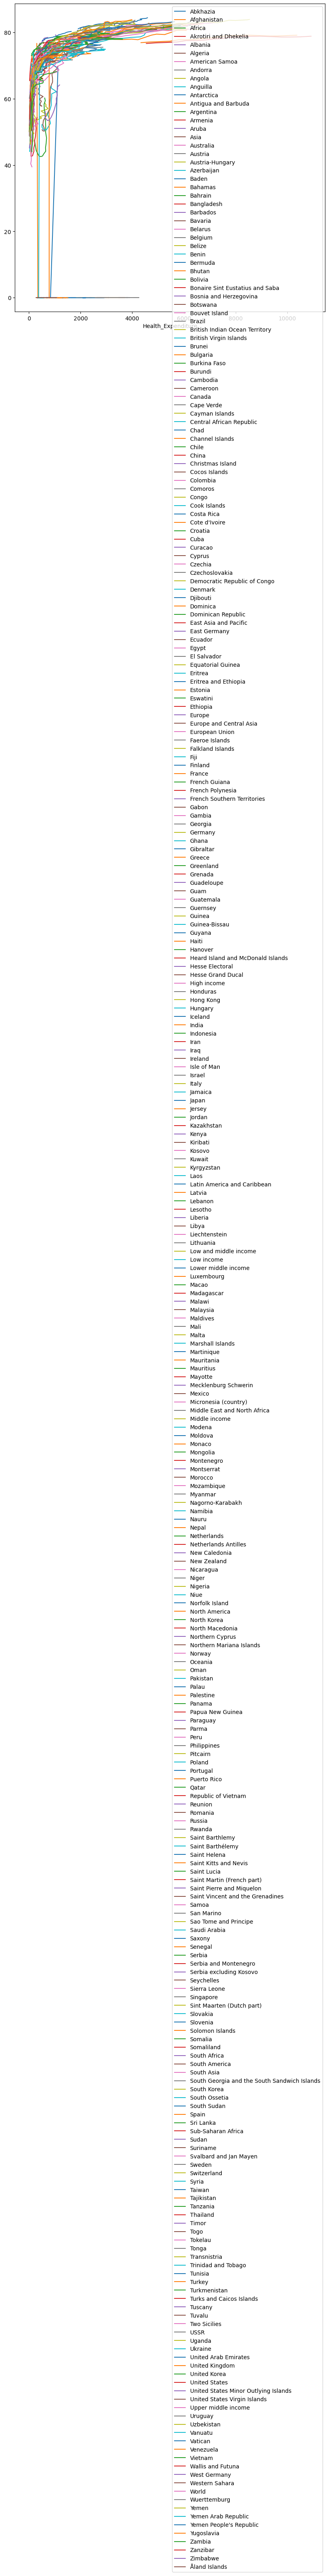

In [6]:
# Imperative Style - more straightforward in the beginning

fig, ax = plt.subplots(figsize=(10,10))

for key, grp in df.groupby(['Country']):
    grp.plot(x='Health_Expenditure', y='Life_Expectancy', label=key, ax=ax)

plt.show()

# Take a look at the plot below. Does it say anything? Hey we plotted rainbow colors and country names?! 
# What can we do about this?

""


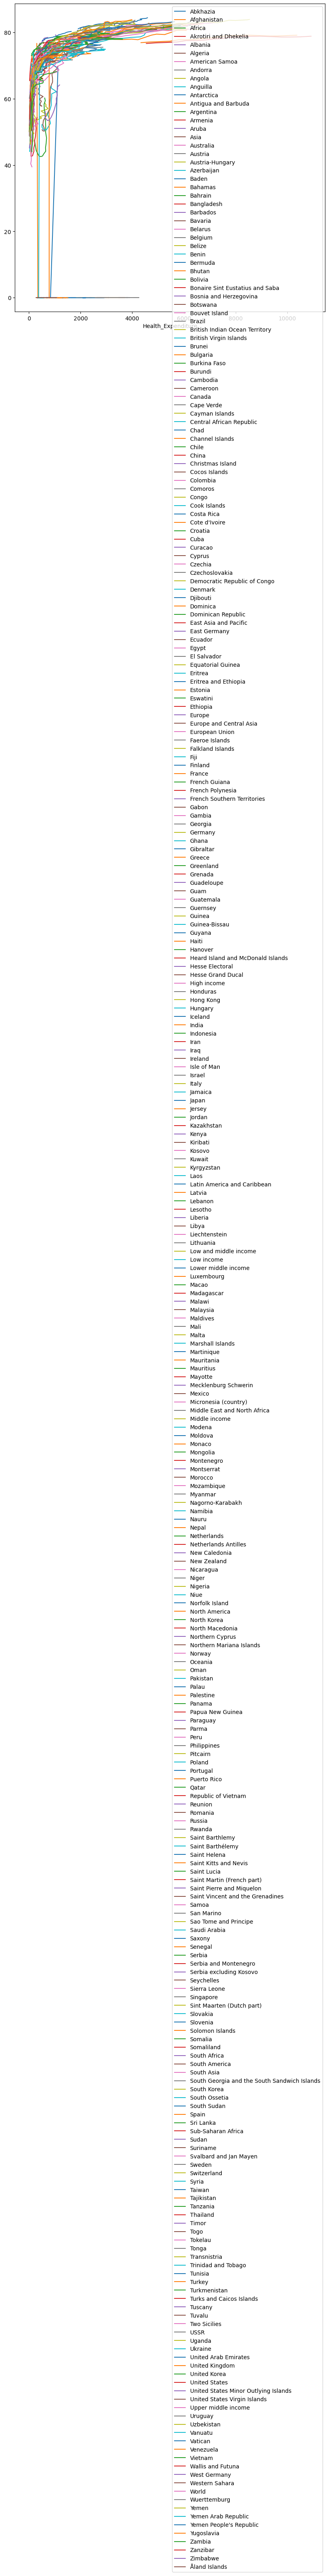

In [7]:
# Functional Style - more extensible
# Slightly different, but clearer way to say the same thing. With the plotting encapsulated into an own function, we can
# refer to it from differently grouped and filtered datasets - great for experimentation
# However, this didn't substantially change our output... yet!

fig, ax = plt.subplots(figsize=(10,10))

def plot_le_vs_he(group, ax):
    group.plot(x='Health_Expenditure', y='Life_Expectancy', label=group.name, ax=ax)

(df
  .groupby('Country')
  .apply(plot_le_vs_he, ax=ax)
)

## Let's do it properly

### Message and Target Audience

1. Let's think about a story and message, we would like to send to our audience. What does the above graph currently say? Apart from: "YAY! Rainbow colors :-)"
2. Define the target group. Whom are we talking to?
3. What is our message? What status quo are we challenging? Which shortcoming would we like to highlight?
4. NO CLUE?! - Let's find out...

### Correlations and Messages

1. A meaningful message may arise from  strong positive or negative correlation between two variables in our dataset. 
2. How can we plot two variables across all our Countries?
3. How do we read the output?
4. What is interesting to us and to our audience here?

### Data Types and Efficiency

1. Before moving on let's take a look at our data and see, how we might do some more data prep.
2. Is the data complete?
3. Are the data types correct and fitting?


### Data Visualization

1. What is our target picture? (e.g. https://twitter.com/__mharrison__/status/1561019274889666562/photo/2)
2. How do we get there?
3. What is our intended medium for output?




In [8]:
# 1. Let's Filter Countries that match US economic life expectancy
# Approach 1: Use a list
# Approach 2: Get the Top 20 countries :-)
# So, the message is: In comparison with the Top 20 Countries in terms of life expectancy, the US spends XYZ

def get_top_countries(df, rank):
    return list((df[['Code','Life_Expectancy']]
      .groupby(['Code'])
      .mean()
      .sort_values('Life_Expectancy', ascending=False)
      .nlargest(rank,'Life_Expectancy')
    ).index)

#get_top_countries(df, 20)

#df[df['Code'].isin(get_top_countries(df, 20) + ['USA'])]

In [9]:
# 2. Let's plot a correlation matrix





In [10]:
# 3. Data Types and Cleaning
# https://realpython.com/python-data-cleaning-numpy-pandas/
# https://www.youtube.com/watch?v=zgbUk90aQ6A


# check the data types in your data set. Do they match or can you become more efficient?
df.dtypes

Country               category
Code                  category
Year                    uint16
Life_Expectancy        float16
Health_Expenditure     float16
Population               Int64
Continent             category
dtype: object

In [11]:
# Check how much memory is being used, perhaps we can change something
df.memory_usage(deep=True).sum()

168401

In [12]:
# Let's check column by column, if we can change something

# 1. Objects to Categorical Values (10M -> 2M)
df['Code'] = df.Code.astype('category')
df['Country'] = df.Country.astype('category')
df['Continent'] = df.Continent.astype('category')

# 2. Floats to smaller floats, Floats to integers
df['Life_Expectancy'].describe()


df.memory_usage(deep=True).sum()

168401

In [13]:
# 2. Floats to smaller floats, Floats to integers (1.5M)
df['Life_Expectancy'].describe()

df['Life_Expectancy'] = df['Life_Expectancy'].astype('float16') # should be within clear limits what life expectancy can be

df['Year'] = df['Year'].astype('uint16') # Years are also within clear positive int bounds
df['Population'] = df['Population'].astype('Int64') # Population and HealthE Expenditure can grow inifinitely though, but Int Values are sensible, too...
df['Health_Expenditure'] = np.floor(pd.to_numeric(df['Health_Expenditure'], errors='coerce')).astype('Int64')

df.memory_usage(deep=True).sum()

196639

In [14]:
df.dtypes

Country               category
Code                  category
Year                    uint16
Life_Expectancy        float16
Health_Expenditure       Int64
Population               Int64
Continent             category
dtype: object

## Last call! Can you find a better visualization?

https://datavizproject.com/

More In-Depth Pandas Tutorials: 
- https://www.youtube.com/watch?v=pjq3QOxl9Ok (Good basic intro coming from core data types)
- https://www.youtube.com/watch?v=Z9ekw2Ou3s0, https://github.com/mattharrison/Idiomatic-Pandas-Tutorial/blob/main/Idiomatic%20Pandas.ipynb (More hands-on and normative looking at an real-world data analysis example


Try and understand the matplotlib hierarchy of objects: 
- https://python-course.eu/numerical-programming/matplotlib-object-hierarchy.php

![](https://python-course.eu/images/numerical-programming/matplotlib_terms_400w.webp)

Text(0.05, 0.03, 'Adapted from @__mharrison__ based on Our World in Data')

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


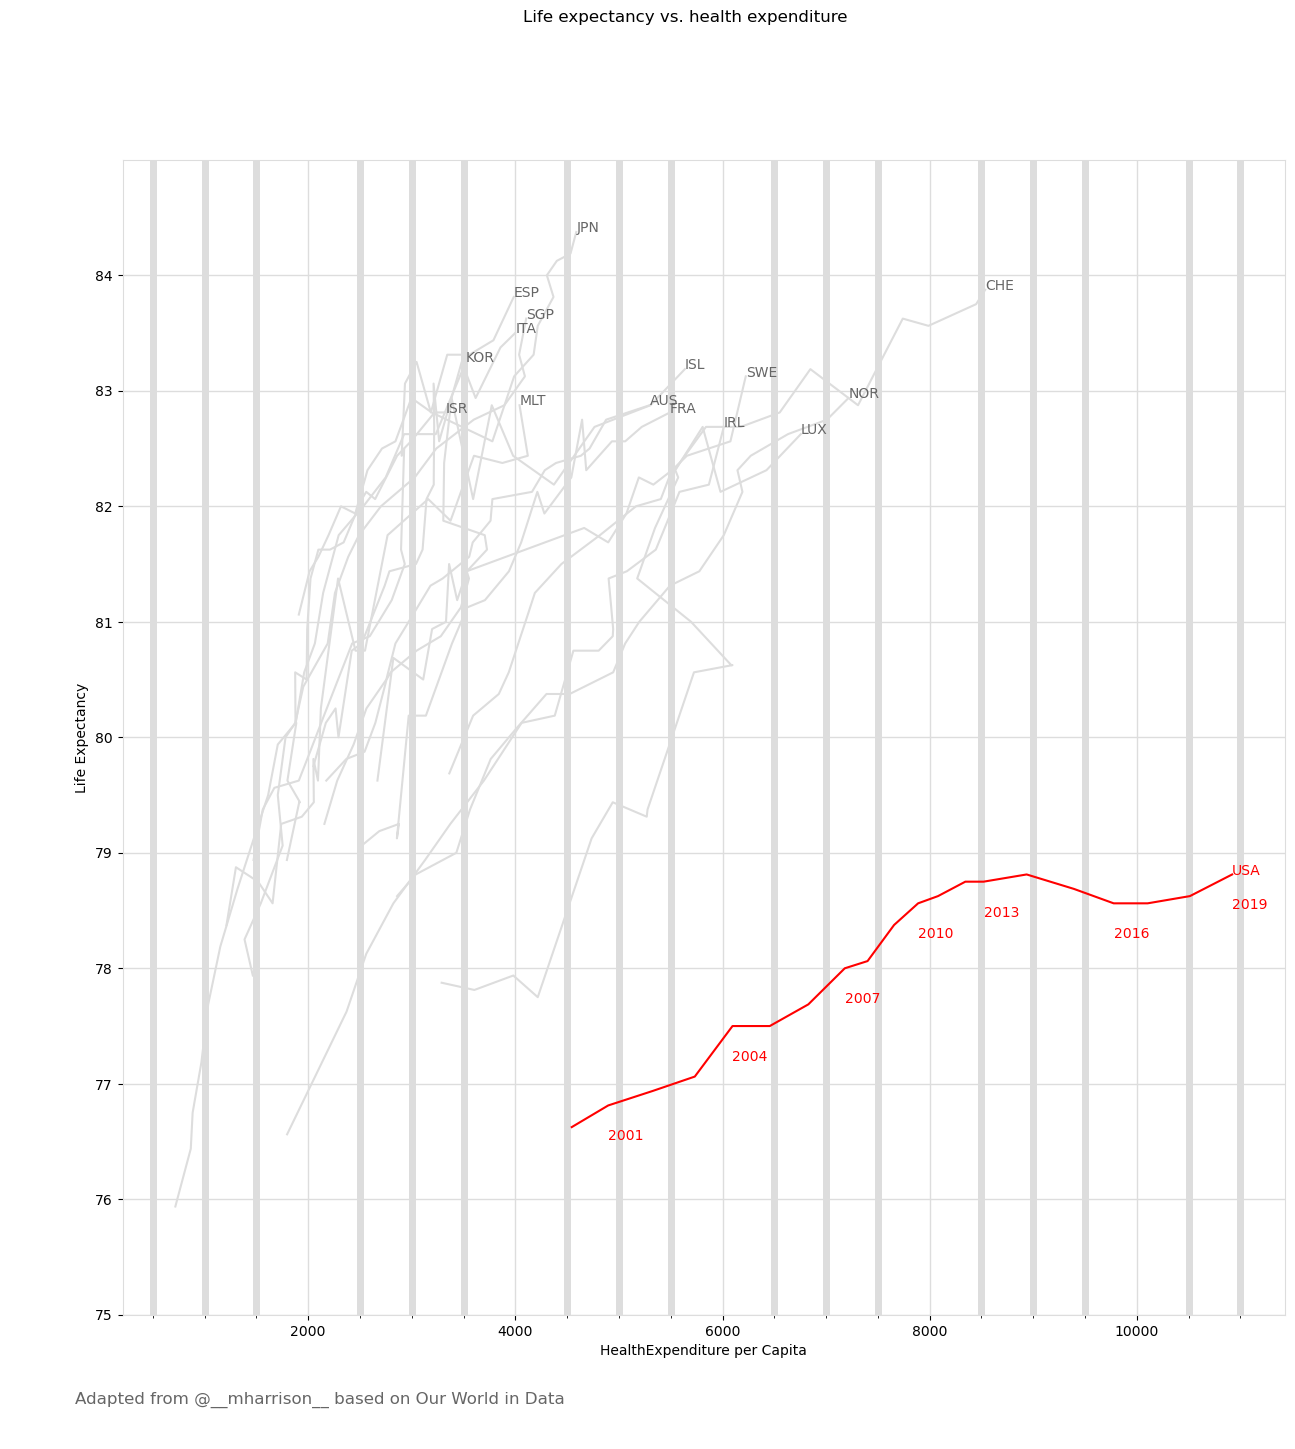

In [15]:
grey = '#ddd'
dark_grey = '#666'
red = 'red'

fig, ax = plt.subplots(figsize=(15,15))

# set axis/tick color globally
for font in ['xtick.color', 'ytick.color', 
             'axes.labelcolor']:
    matplotlib.rcParams[font] = dark_grey
    

# run through all groups and set colors and labels
# set plot of USA to red and add year labels to data points
def plot_le_vs_he(group, ax):
    name = group.name
    color = grey
    text_color = dark_grey
    if name == 'USA':
        color = red
        text_color = red
        for idx, row in group.iterrows():
            if row.Year % 3 != 0:
                continue
            ax.text(row.Health_Expenditure, 
                    row.Life_Expectancy - .3, row.Year, color=color)
    group = group.sort_values('Year')
    group.plot(x='Health_Expenditure', y='Life_Expectancy', ax=ax, c=color, legend=False)
    if len(group.values) > 0:
        ax.text(group.Health_Expenditure.iloc[-1], 
            group.Life_Expectancy.iloc[-1], name, color=text_color)



(df
.groupby('Code')
.filter(lambda g: (g.Life_Expectancy.max() > 82.5) | (g.name == 'USA'))
.groupby('Code')
.apply(plot_le_vs_he, ax=ax)
)

# set range of 
y_range = (75,85)
ax.set_ylim(*y_range)
 
#set ticks
ax.set_yticks(range(*y_range, 1))
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(500))
 
#add grid
ax.grid(visible=True, which='major', linewidth=1, zorder=0, color=grey)
ax.grid(visible=True, which='minor', linewidth=5, zorder=0, color=grey)
 
# spine color
for side in 'top,left,right,bottom'.split(','):
     ax.spines[side].set_color(grey)

        
# axis labels        
ax.set_ylabel('Life Expectancy')
ax.set_xlabel('HealthExpenditure per Capita')

# figure title
fig.suptitle('Life expectancy vs. health expenditure')

# axes annotation
ax.annotate('Adapted from @__mharrison__ based on Our World in Data',
                xy=(0,0), xytext=(.05,.03), textcoords='figure fraction', 
                xycoords='figure fraction', color=dark_grey, fontfamily='Roboto', fontsize=12)


## Analysis

### Message and Data:

- overall clearer message: compare US spending and population health effect with other countries
- slightly biased though, no context about countries being worse

### Visualization

- Connection between the years could be cleaer 

In [16]:
(df
 .query('Health_Expenditure.notna()')
)

,Country,Code,Year,Life_Expectancy,Health_Expenditure,Population,Continent
43,Afghanistan,AFG,2002,56.78125,81,22600774,NaN
44,Afghanistan,AFG,2003,57.28125,82,23680871,NaN
45,Afghanistan,AFG,2004,57.78125,89,24726689,NaN
46,Afghanistan,AFG,2005,58.28125,100,25654274,NaN
47,Afghanistan,AFG,2006,58.81250,113,26433058,NaN
...,...,...,...,...,...,...,...
56332,Zimbabwe,ZWE,2015,59.53125,199,13814642,Africa
56333,Zimbabwe,ZWE,2016,60.28125,215,14030338,NaN
56334,Zimbabwe,ZWE,2017,60.81250,226,14236599,NaN
56335,Zimbabwe,ZWE,2018,61.18750,269,14438812,NaN


In [17]:
df.Health_Expenditure.describe()

count     4034.000000
mean      1126.255578
std       1466.335919
min          6.000000
25%        170.250000
50%        540.000000
75%       1454.000000
max      10920.000000
Name: Health_Expenditure, dtype: float64

In [18]:
gdf = (df
.groupby('Code')
.filter(lambda g: (g.Life_Expectancy.max() > 80) | (g.name == 'USA'))
.groupby('Code')
)



NameError: name 'df' is not defined